# Train a BNN to classify MNIST using neural SVGD

In [1]:
# for leonhard
import os
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
os.environ['XLA_FLAGS']

'--xla_gpu_cuda_data_dir=/cluster/apps/gcc-6.3.0/cuda-10.1.243-n6qg6z5js3zfnhp2cfg5yjccej636czm'

In [3]:
# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
%load_ext autoreload
import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/")

import argparse
import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax

from nvgd.src import models, metrics, utils
from nvgd.experiments import bnn, dataloader
from nvgd.experiments import config as cfg

from jax import jit, grad, value_and_grad

# Config
key = random.PRNGKey(0)
MAX_TRAIN_STEPS = 100  # df 100
META_LEARNING_RATE = 5e-4  # df 1e-3; should be as high as possible; regularize w/ max steps
PATIENCE = 5  # df 5; early stopping not v helpful, bc we overfit on all ps

NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 1/2
STEP_SIZE = 4e-5
PATIENCE = 15
MAX_TRAIN_STEPS = 100

Loading data...


# init particles and dynamics model

In [4]:
def init_particles_fn(subkey):
    init_particles = vmap(bnn.init_flat_params)(random.split(subkey, NUM_SAMPLES))
    return init_particles


key, subkey = random.split(key)
init_particles = init_particles_fn(subkey)
opt = optax.sgd(STEP_SIZE)

minibatch_vdlogp = jit(vmap(grad(bnn.minibatch_logp), (0, None)))

init_particles.shape

(100, 4594)

In [4]:
# maximal initial stein discrepancy (theoretical ideal)
import plot
import stein
from jax.scipy import stats

n, d = init_particles.shape
n = 100
key, subkey = random.split(key)
xs = random.normal(subkey, (n, d)) / 100

first_batch = next(mnist.training_batches)
images, labels = first_batch

def logp(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels)
    return loglikelihood(x) + bnn.log_prior(bnn.unravel(x))


def logq(x):
    return stats.norm.logpdf(x, loc=0, scale=1/100).sum()


def f(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels) / (2*LAMBDA_REG)
    return grad(loglikelihood)(x)

# double-check stein discrepancy

# a) true
l2 = utils.l2_norm_squared(xs, f) # = sd(f*) / (2 LAMBDA_REG)
true_sd = 2 * LAMBDA_REG * l2
min_loss = -l2 * LAMBDA_REG

# b) hutchinson
key, subkey = random.split(key)
random_estimate_sd = stein.stein_discrepancy_hutchinson(subkey, xs, logp, f)

print("analytical sd:", true_sd)
print("hutchinson estimate:", random_estimate_sd)
print("ratio:", true_sd / random_estimate_sd)

analytical sd: 837803800.0
hutchinson estimate: 837107200.0
ratio: 1.0008321


In [5]:
# class MixedVGD(SteinNetwork):
#     def __init__(*args, **kwargs):
#         """initialize network parameters"""
        
        
#     def get_field():
#         """return -(f_theta + phi_kernel)"""
        

In [8]:
svgd_grad = models.KernelGradient(get_target_logp=bnn.get_minibatch_logp,
                                  scaled=False,
                                  lambda_reg=LAMBDA_REG)

v, h = svgd_grad.get_field(particles.particles, first_batch)
SVGD_SCALE = 1e-4 / STEP_SIZE
scaled_grad = lambda x: - v(x)

# fixed
key, subkey = random.split(key)
split_particles = particles.next_batch(subkey)
split_dlogp = [minibatch_vdlogp(x, first_batch)
               for x in split_particles]
dlogp = jnp.append(*split_dlogp, axis=0)

In [9]:
ksd = stein.stein_discrepancy_hutchinson_fixed_log(subkey,
                                                   particles.particles,
                                                   dlogp,
                                                   scaled_grad)
print(ksd)
print(true_sd)

857720.5
837803800.0


In [12]:
neural_grad3 = models.SteinNetwork(target_dim=init_particles.shape[1],
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes=[256, 256, 256, init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=True,
                               lambda_reg=LAMBDA_REG,
                               patience=PATIENCE,
                               dropout=False,
                               normalize_inputs=True,
                               extra_term=scaled_grad)

In [ ]:
stein.stein_discrepancy_hutchinson_fixed_log(subkey,
                                           particles.particles,
                                           dlogp,
                                           neural_grad3.get_field())

In [17]:
neural_grad3.train(
    split_particles=split_particles,
    split_dlogp=split_dlogp,
    n_steps=100,
    early_stopping=False,
)

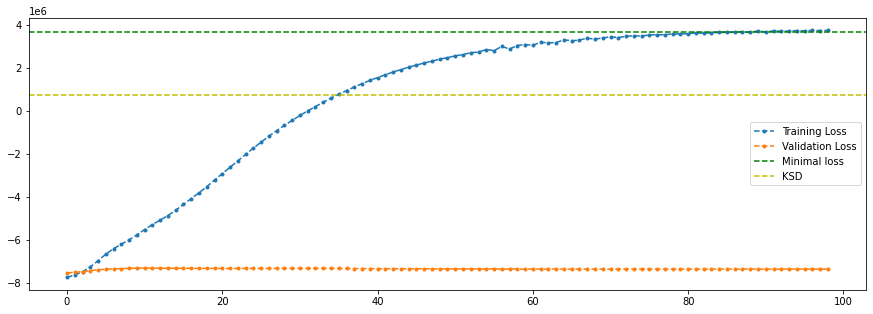

In [23]:
# generate markings based on num_steps
a = 0
b = -1
plt.subplots(figsize=[15, 5])
plt.plot(neural_grad3.rundata['training_sd'][a:b], "--.", label="Training Loss")
plt.plot(neural_grad3.rundata['validation_sd'][a:b], "--.", label="Validation Loss")

# plt.scatter(markings, onp.zeros(len(markings)))
plt.axhline(y=true_sd, label="Minimal loss", linestyle="--", color="g")
plt.axhline(y=ksd, label="KSD", linestyle="--", color="y")
plt.legend()